### Use Case: Classify BBC Articles

### Problem Case: 
- Build a predictive model to classify news article basis 5 different categories
- Explore different algorithms to comapre accuracies of Naive Bayes Classfier

### Flow of NLP projects
 <img src="images/nlpflow.png" alt="nlp_flow" style="width:80%;height:200px;">

 <img src="images/dtm_2.png" alt="dtm" style="width:80%;height:200px;">

### 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Iteratively read files
import glob
import os

# For displaying images in ipython
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

### 2. Load data

In [2]:
os.getcwd()

'/Users/paragpradhan/Documents/Data Science Course/DS-Intro/8.Text_Mining'

In [2]:
# User defined function to read and store bbc data from multipe folders
def load_data(folder_names,root_path):
    fileNames = [path + '/' + 'bbc' +'/'+ folder + '/*.txt' for path,folder in zip([root_path]*len(folder_names),
                                                                               folder_names )]
    doc_list = []
    tags = folder_names
    for docs in fileNames:
        #print(docs)
        #print(type(docs))
        doc = glob.glob(docs) # glob method iterates through the all the text documents in a folder
        for text in doc:
            with open(text, encoding='latin1') as f:
                topic = docs.split('/')[len(docs.split('/'))-2]

                lines = f.readlines()
                heading = lines[0].strip()
                body = ' '.join([l.strip() for l in lines[1:]])
                doc_list.append([topic, heading, body])
        print("Completed loading data from folder: %s"%topic)
    
    print("Completed Loading entire text")
    
    return doc_list

In [3]:
folder_names = ['business','entertainment','politics','sport','tech']
docs = load_data(folder_names = folder_names, root_path = os.getcwd())

Completed loading data from folder: business
Completed loading data from folder: entertainment
Completed loading data from folder: politics
Completed loading data from folder: sport
Completed loading data from folder: tech
Completed Loading entire text


In [4]:
docs = pd.DataFrame(docs, columns=['Category', 'Heading', 'Article'])
print(docs.head())
print('\nShape of data is {}\n'.format(docs.shape))
print(docs.info())

   Category                            Heading  \
0  business    UK economy facing 'major risks'   
1  business  Aids and climate top Davos agenda   
2  business   Asian quake hits European shares   
3  business   India power shares jump on debut   
4  business    Lacroix label bought by US firm   

                                             Article  
0   The UK manufacturing sector will continue to ...  
1   Climate change and the fight against Aids are...  
2   Shares in Europe's leading reinsurers and tra...  
3   Shares in India's largest power producer, Nat...  
4   Luxury goods group LVMH has sold its loss-mak...  

Shape of data is (2225, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
Category    2225 non-null object
Heading     2225 non-null object
Article     2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB
None


In [5]:
tags_values = docs['Category'].value_counts()
tags_values

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64

### 3. Explore data

In [ ]:
!pip install wordcloud

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [7]:
heading_sport = docs[docs["Category"]=="sport"]["Heading"] # Extract only heading of emails for Ham tags
collapsed_heading_sport = heading_sport.str.cat(sep=' ')

heading_business = docs[docs["Category"]=="business"]["Heading"] # Extract only heading of emails for spam tags
collapsed_heading_business = heading_business.str.cat(sep=' ') # Combining all the emails into one large text

heading_politics = docs[docs["Category"]=="politics"]["Heading"] # Extract only heading of emails for Ham tags
collapsed_heading_politics = heading_politics.str.cat(sep=' ')

heading_tech = docs[docs["Category"]=="tech"]["Heading"] # Extract only heading of emails for spam tags
collapsed_heading_tech = heading_tech.str.cat(sep=' ') # Combining all the emails into one large text

heading_entertainment = docs[docs["Category"]=="entertainment"]["Heading"] # Extract only heading of emails for spam tags
collapsed_heading_entertainment = heading_entertainment.str.cat(sep=' ') # Combining all the emails into one large text


Word Cloud for Sports


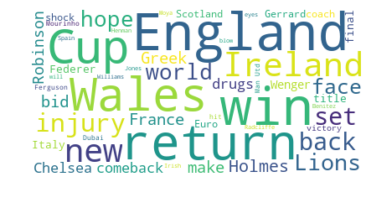


Word Cloud for Business


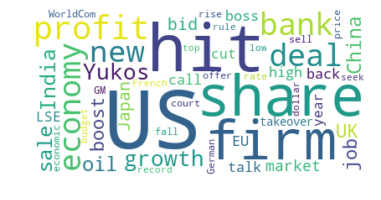


Word Cloud for Politics


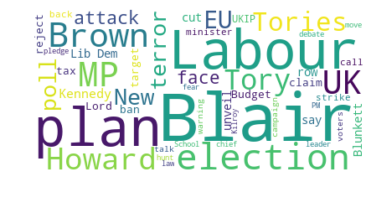


Word Cloud for Technology


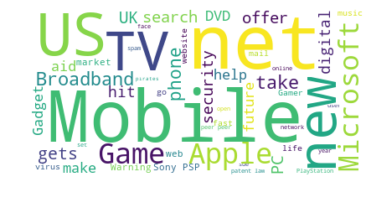


Word Cloud for Entertainment


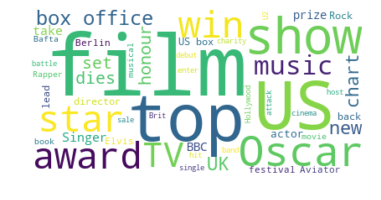

In [8]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["Subject","re","fw","fwd"])

print("Word Cloud for Sports")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_sport)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Business")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_business)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Politics")
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_politics)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Technology")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_tech)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
     
print("\nWord Cloud for Entertainment")
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_entertainment)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Preprocess & Transform Text Data

In [9]:
# Building Pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

### 5. Split data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(docs["Heading"], docs["Category"],random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((1780,), (445,), (1780,))

### 6. Train the model

In [11]:
model = clf.fit(X_train,y_train)

In [12]:
print("Accuracy of Naive Bayes Classifier is {}".format(model.score(X_test,y_test)))

Accuracy of Naive Bayes Classifier is 0.8


### 7. Validate the model

In [13]:
# Predict on Test data
y_predicted = model.predict(X_test)
y_predicted[0:10]

array(['business', 'business', 'sport', 'business', 'politics', 'sport',
       'sport', 'business', 'entertainment', 'politics'], dtype='<U13')

In [14]:
#Confusion Matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted)
np.set_printoptions(precision=2)
cnf_matrix

array([[84,  3, 18,  7,  3],
       [ 3, 60,  3,  5,  1],
       [ 6,  1, 63,  5,  1],
       [ 7,  2,  3, 89,  1],
       [ 8,  2,  4,  6, 60]])

In [15]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[84  3 18  7  3]
 [ 3 60  3  5  1]
 [ 6  1 63  5  1]
 [ 7  2  3 89  1]
 [ 8  2  4  6 60]]
Normalized confusion matrix
[[0.73 0.03 0.16 0.06 0.03]
 [0.04 0.83 0.04 0.07 0.01]
 [0.08 0.01 0.83 0.07 0.01]
 [0.07 0.02 0.03 0.87 0.01]
 [0.1  0.03 0.05 0.07 0.75]]


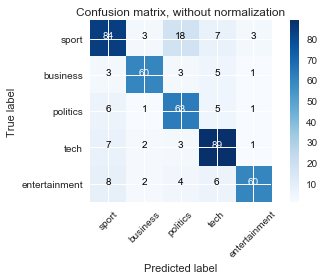

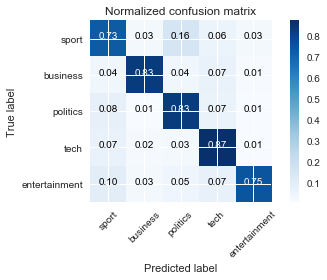

In [16]:
#With Normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['sport','business','politics','tech','entertainment'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['sport','business','politics','tech','entertainment'], normalize=True,title='Normalized confusion matrix')

plt.show()

### Trying out Decision Trees

In [17]:
# Building Pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', DecisionTreeClassifier()),
    ])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(docs["Heading"], docs["Category"],random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((1780,), (445,), (1780,))

In [19]:
model = clf.fit(X_train,y_train)

In [20]:
print("Accuracy of Naive Bayes Classifier is {}".format(model.score(X_test,y_test)))

Accuracy of Naive Bayes Classifier is 0.6786516853932584


### Trying out Random Forest Classfier

In [21]:
# Building Pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(docs["Heading"], docs["Category"],random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((1780,), (445,), (1780,))

In [23]:
model = clf.fit(X_train,y_train)

/Users/paragpradhan/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
print("Accuracy of Naive Bayes Classifier is {}".format(model.score(X_test,y_test)))

Accuracy of Naive Bayes Classifier is 0.6808988764044944


### Trying out Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
# Building Pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression()),
    ])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(docs["Heading"], docs["Category"],random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((1780,), (445,), (1780,))

In [28]:
model = clf.fit(X_train,y_train)

/Users/paragpradhan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paragpradhan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [29]:
print("Accuracy of Logistic Regression is {}".format(model.score(X_test,y_test)))

Accuracy of Logistic Regression is 0.8089887640449438
